In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #visualization
%matplotlib inline
import seaborn as sns
from nltk import sent_tokenize, word_tokenize  #tokenization
from nltk.tokenize import MWETokenizer #multi-word-tokenization
import re  #regular expressions
import spacy  #part-of-speech tagging
from gensim.models.fasttext import FastText
from sklearn.metrics.pairwise import cosine_similarity  #similarities
import pyLDAvis.gensim  #topic model
import warnings

/opt/conda/lib/python3.7/site-packages/past/types/oldstr.py:36: DeprecationWarning: invalid escape sequence \d
  """


In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
dataset = pd.read_csv('../input/sentisumtopics/sentisum-assessment-dataset.csv', usecols = [0], names = ['Review'])

# Section 1 : Preprocessing

In [4]:
def normalize_data(data, keep_nonascii = False, keep_punctuation = False, remove_extra_spaces = True, lowercase = True, word_length = None):
    """
    Performs specific cleaning operations on the data, as long as the data is a string.
    :param data: string representing review
    :param keep_nonascii: boolean value representing whether to keep non-ascii characters or not
    :param keep_punctuation: boolean value representing whether to keep punctuation or not
    :param remove_extra_spaces: boolean value representing whether to remove extra spaces between, before, and after words
    :param lowercase: boolean value representing whether to lowercase data or not
    :param word_length: if None, word length is not taken into account. If it is a number, only words greater than or equal to specific length will be kept.
    :return: normalized string
    """
    assert type(data) == type('Document'),"Your data is not a string."
    temp_data = data
    if not keep_nonascii:
        temp_data = temp_data.encode('ascii', errors = 'ignore')
    if not keep_punctuation:
        regular_expression = re.compile('[' + re.escape('!@#$^&*\'()+=-_,./:;<>?"[\\]^_`{|}~')+'0-9\\r\\t\\n]')
        temp_data = regular_expression.sub(' ', temp_data.decode('utf-8'))
    if remove_extra_spaces:
        split_data = temp_data.split(' ')
        just_words = [word.strip() for word in split_data if word not in ['','\r','\t',' ']]
        temp_data = ' '.join(split_data)
    if lowercase:
        temp_data = temp_data.lower()
    if word_length:
        assert type(word_length) == type(5)
        split_data = temp_data.split(' ')
        select_words = [word.strip() for word in split_data if len(word)>=word_length]
        temp_data = ' '.join(split_data)
        
    return temp_data
        
    

In [5]:
def tokenize(data):
    """
    Function to tokenize data. Best used AFTER stopword removal, contraction replacement, and normalization. 
    Best used before lemmatization and POS tagging.
    :param data: string representing review
    :return: tokenized string as list of tokens
    """
    assert type(data) == type('Document'), "Your data is not a string."
    return word_tokenize(data)

In [6]:
def replace_contractions(data, contractions):
    """
    Function to replace contractions in data. Best used BEFORE normalization.
    :param data: string representing review
    :param contractions: dictionary of predefined contractions and their expansions
    :return: string with contractions replaced
    """
    assert type(data) == type('Document'), "Your data is not a string."
    assert type(contractions) == type({}), "Your contractions are not in a dictionary."
    
    contraction_list = contractions.keys()
    temp_data = str(data.lower()).split()
    for i in range(len(temp_data)):
        if temp_data[i] in contraction_list:
            temp_data[i] = contractions[temp_data[i]]
    data = ' '.join(temp_data)
    return data    

In [7]:
def lemmatize(data, lemmatizer):
    """
    Function to lemmatize data. Best used BEFORE tokenization and AFTER normalization.
    :param data: string representing review
    :param lemmatizer: NLTK/Spacy lemmatizer object
    :return: string with lemmas only
    """
        
    assert type(data) == type('Document'), "Your data is not a string."
    lemmas = []
    sentences = sent_tokenize(data)
    for s in sentences:
        processed_sentence = lemmatizer(s)
        lemmas.extend([word.lemma_ for word in processed_sentence])
    return ' '.join(lemmas)


In [8]:
def clean_pos_tags(data, relevant_tags, general_category = True):
    """
    Function to remove unnecessary words by filtering out based on part of speech. 
    Best used AFTER normalization and contraction replacement, but BEFORE other steps.
    :param data: string representing review
    :param relevant_tags: list of NLTK POS tags to keep
    :param general_category: if True, you only need to specify general categories like JJ, NN, and it will take subcategories too.
    :return: string with required words only
    """
    assert type(data) == type('Document'), "Your data is not a string."
    assert type(relevant_tags) == type([]), "Your POS tags are not in a list."
    
    tagged_data = nltk.pos_tag(data.split())
    # print(tagged_data)
    if general_category:
        kept_words = [tag_pair[0] for tag_pair in tagged_data if tag_pair[1].startswith(tuple(relevant_tags))]
    else:
        kept_words = [tag_pair[0] for tag_pair in tagged_data if tag_pair[1] in relevant_tags]
    return ' '.join(kept_words)

In [9]:
def remove_stopwords(data, stopwords): 
    """
    Function to remove stopwords from data. Best used AFTER normalization.
    :param data: string representing review
    :param stopwords: list of stopwords to be removed
    :return: string with stopwords removed
    """

    assert type(data) == type('Document'), "Your data is not a string."
    assert type(stopwords) == type([])

    split_data = data.split(' ')
    cleaned_data = [word.strip() for word in split_data if word not in stopwords and len(word)>3]
    new_data = ' '.join(cleaned_data)
    return new_data

In [10]:
def replace_multi_words(data, multi_dict):
    
    """
    Function to replace common multi-words in data.
    :param data: string representing review
    :param multi_dict: dictionary representing mutli-words to combine.
    :return: string with replaced multi-words
    """
    
    assert type(data) == type('Document'), "Your data is not a string."
    assert type(multi_dict) == type({}), "Your multi-word dictionary is not a dictionary."
    
    new_data = str(data)
    for replacement in multi_dict.keys():
        if re.search(replacement, data):
            new_data = re.sub(replacement, multi_dict[replacement], new_data)
    return new_data

In [11]:
def generate_ngrams(data, column = 'Review', n = 2, frequency = 20, best_number = 10, min_pmi = 4, stopwords_list = stopwords.words('english')):
    """
    Function to generate the most common co-occuring phrases in the data.
    :param data: dataframe representing reviews list
    :param column: column name to consider
    :param n: integer representing the number of words to consider for an n-gram. Can take values 2 or 3.
    :param frequency: integer value showing the minimum frequency of n-gram to be considered.
    :param best_number: value determining how many n_grams to return
    :param min_pmi: minimum pmi value to keep
    :param stopwords_list: sequence of stopwords
    :return: list of n-grams for the data
    """
    
    assert type(data) == type(pd.DataFrame(columns = ['x'])), "Your data is not a dataframe."
    assert type(column) == type('Document'), "Your data is not a string."
    assert column in data.columns, "Invalid column name"
    assert type(n) == type(int(5)), "Your n value is not an integer."
    assert n in [2,3], "Incorrect value of n."
    assert type(frequency) == type(int(1)), "Your frequency value is not an integer."
    assert frequency > 0, "Your frequency does not fall into the appropriate range."
    assert type(min_pmi) == type(int(1.0)), "Your minimum PMI is not a floating point number."
    assert min_pmi > 0, "Your minimum PMI does not fall into the appropriate range."
    assert type(best_number) == type(int(5)) and best_number>0, "Best number is not an integer greater than 0"
    assert type(stopwords_list) in [type([]), type({'x':1}.keys())], "Stopwords are not in the right format"
    
    final_list = []
    
    
    if n == 2:
        bigram_collocations = nltk.collocations.BigramAssocMeasures()
        total_list = nltk.collocations.BigramCollocationFinder.from_documents([review.lower().split() for review in data[column]])
        total_list.apply_freq_filter(frequency)        
        scores = total_list.score_ngrams(bigram_collocations.pmi)
    elif n == 3:
        trigram_collocations = nltk.collocations.TrigramAssocMeasures()
        total_list = nltk.collocations.TrigramCollocationFinder.from_documents([review.split() for review in data[column]])
        total_list.apply_freq_filter(frequency)
        scores = total_list.score_ngrams(trigram_collocations.pmi)
    
    ngram_df = pd.DataFrame(scores, columns = ['ngram', 'pmi'])
    ngram_df = ngram_df.sort_values(by = 'pmi', axis = 0, ascending = False)
    to_keep = []
    
    for i in range(len(ngram_df)):
        ngram_val = ngram_df.loc[i, 'ngram']
        # print(ngram_val)
        tagged_ngram = nltk.pos_tag(ngram_val)
        ngram_df.loc[i, 'pos'] = str(tagged_ngram)
        # print(tagged_ngram)
        if n == 2:
            if (tagged_ngram[0][1] not in ['NN', 'JJ', 'VBG'] and tagged_ngram[1][1] not in ['NN']) or tagged_ngram[0][0] in stopwords_list or tagged_ngram[1][0] in stopwords_list or 'n' in ngram_val or 't' in ngram_val:
                to_keep.append(False)
            else:
                to_keep.append(True)
        elif n == 3:
            if (tagged_ngram[0][1] not in ['NN', 'JJ'] and tagged_ngram[2][1] not in ['NN']) or tagged_ngram[0][0] in stopwords_list or tagged_ngram[1][0] in stopwords_list or tagged_ngram[2][0] in stopwords_list or 'n' in ngram_val or 't' in ngram_val:
                to_keep.append(False)
            else:
                if tagged_ngram[0][0] == tagged_ngram[2][0]:
                    to_keep.append(False)
                else:
                    to_keep.append(True)
                
    tagged_list = ngram_df[to_keep][ngram_df['pmi'] > min_pmi]
    final_list = tagged_list['ngram']
    tagged_list.reset_index(inplace = True)
                     
    return final_list[:best_number], tagged_list

In [12]:
contractions_dict = {"aren t" : "are not", "can t" : "cannot", "couldnt":"could not", "couldn t" : "could not", "didn t" : "did not", "doesn t" : "does not", "don t" : "do not", "haven t" : "have not", "hasn t" : "has not" , "hadn t" : "had not", "i m" : "i am", "i ve" : "i have", "isn t" : "is not", "it's" : "it is" , "mustn t" : "must not", "shouldn t" : "should not", "wasn t" : "was not", "weren t" : "were not", "wouldn t" : "would not", "won t":"will not", "you re" : "you are", "you ll" : "you will" , "we ll" : "we will", "you ve" : "you have", "we ve" : "we have"}
replacements = {"nt":"not", "timethanks":"time thanks", "s" : "", "f":"", "mot":"not", "tyer":"tyre","ve":"have", "Ive" : "i have", "ive":"i have", "m":"am","hassel":"hassle", "sevice":"service", "payby":"pay by", "cheapestefficient":"cheapest efficient", "hadn‚äôt": "had not", "excellenttttttttttttttytt":"excellent", "pricestyres":"prices. tyres", "defo":"definitely", "helpfu":"helpful", "fittingwhat":"fitting what",  "3tyres":"3 tyres", "appt":"appointment", "appts":"appointments", "inbtyre":"in tyre", "plus":"and", "on-line":"online", "definatly":"definitely", "comunication":"communication", "stocka":"stock. a", "fittedcompetitive":"fitted. competitive","garrage":"garage",  "tire":"tyre", "v":"very", "hrs":"hours", "specialoffer":"special offer", "im":"i am", "bkack":"black", "min":"minutes", "mins":"minutes",  "tweeking":"tweaking", "serviceno":"service. no", "timesays":"time says", "sped":"speed", "70pound":"70 pound", "defiantly":"definitely", "tyreseasy": "tyres. easy", "fittinggreat":"fitting. great", "mebest":"me. best", "t5he":"the", "quality's":"quality", "tyreswithout":"tyres without",  "appoint":"appointment", "fortyres":"for tyres", "servicewould":"service. would", "trued":"tried",  "45minutes":"45 minutes", "welcombe":"welcome", "againshoutout":"again. shoutout", "def":"definitely", "andfitting":"and fitting", "aswell":"as well", "efficienct":"efficient", "ordergarage":"order. garage", "&":"and","chap":"cheap", "tyers":"tyres", "ive":"i have", "alignmentwasted":"alignment. wasted", "offergreat":"offer. great", "fitterwould":"fitter. would", "reasonabke":"reasonable", "cant":"cannot","pricesthe":"prices. the","ture":"tyre"," t.he ":" the ","coz":"because","cos":"because","ourchas3":"purchase","exelent":"excellent","competative":"competitive", "complaintsmy":"complaints. my", "[redacted]":"company", "fir":"for", "veiwe" : "waive","tires" : "tyres", "tire" : "tyre",  "hassle-free":"hassle free", "extrau":"extra. you", "u":"you", "nurlly":"nearly","tyresgreat":"tyres. great", "pricegreat":"price. great", "web-page": "webpage", "agreat":"a great", "reccomend":"recommend", "3td": "3rd", "1hour":"1 hour", "ordergood":"order. good", "pricesall":"prices. all", "garagewould":"garage. would", "a d":"and", "goodbadgreat":"good bad great","effecient":"efficient", "mmet":"meet", "minuets":"minutes", "alsop":"also","seribe":"service", "mitchelin":"michelin","atsdisappointed":"ats. disappointed", "reg":"registration", "gd":"good", "priceoriginal":"price. original", "whats":"what is", "servicegreat":"service. great","tyrestotally":"tyres totally", "rd":"road", "chse":"chose", "choicefitted":"choice. fitted", "orderingvery":"ordering. very", "fithassle":"fit hassle", "fittedi":"fitted","servicd":"service", "competetive":"competitive", "2front":"2 front", "servicel":"service", ".com":" ", "gr8":"great", "prii":"price", "priceservice":"price service", "am/pm":"am pm", "s":"is", "d":"the", "pricr":"price", "a.m":"am", "p.m":"pm","againsuperbthank":"again. superb. thank", "preffered":"preferred", "ya":"you", "simly":"simply", "amade":"made", "frist":"first", "budged":"budget", "cant":"cannot", "profesional":"professional", "i‚äôm": "i am"}
multi_words = {"ca nt":"cannot", "fault less":"faultless", " dont bargains ":" do not bargain ", " a m ":" am ", " p m ":" pm ", " a t s ":" ats ", " web page ":" webpage ", " on line ": " online ", " web site " : " website ", " straight forward ":" straightforward ", " bench mark ":" benchmark ", " findingself explantory ":" finding self explanatory ", " web site ":" website ", " ould ha e ":" could have " }
multi_words.update(contractions_dict)
stopwords_ngram = stopwords.words('english') + ['ive', 'use', 'used', 'using']

In [13]:
dataset['Normalized'] = dataset['Review'].apply(lambda x: replace_multi_words(normalize_data(replace_contractions(x, contractions = replacements), word_length = 3), multi_words))

In [14]:
dataset.sample(10)

,Review,Normalized
9180,"Staff very friendly, offered a drink while i w...",staff very friendly offered a drink while i w...
6781,quick and reliable,quick and reliable
683,I ordered my tyre and was given a installed da...,i ordered my tyre and was given a installed da...
9159,"good priced tyres, convieniently fitted at a l...",good priced tyres convieniently fitted at a l...
1859,Great value no hassle to arrange fitting,great value no hassle to arrange fitting
3913,Cheapest tyres around with local fitting.What ...,cheapest tyres around with local fitting what ...
8804,Good range of tyres at good prices. Arrangemen...,good range of tyres at good prices arrangemen...
9087,Buying tyres from [REDACTED] was very easy. I ...,buying tyres from company was very easy i vie...
8501,"Good price, tyres were delivered promptly to f...",good price tyres were delivered promptly to f...
4504,1 of the tyres was an old tyre. I have bought ...,of the tyres was an old tyre i have bought ...


In [15]:
trigrams, _ = generate_ngrams(dataset, 'Normalized', n = 3, frequency = 16, best_number = 13, stopwords_list = stopwords_ngram)
trigrams = [' '.join(gram) for gram in trigrams.values]
trigrams.append('next day delivery')
bigrams, _ = generate_ngrams(dataset, 'Normalized', n = 2, frequency = 30, best_number = 72, stopwords_list = stopwords_ngram)
bigrams = [' '.join(gram) for gram in bigrams.values]
try:
    bigrams.remove('st class')
    bigrams.remove('cannot fault')
    bigrams.remove('cant fault')
except:
    print("No such bigram")

ngrams = bigrams + trigrams

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


No such bigram


In [16]:
bigrams

['cost effective',
 'wheel nuts',
 'wheel alignment',
 '% discount',
 'cannot fault',
 'redacted com',
 'wide range',
 'several times',
 'first class',
 'phone call',
 'whole process',
 'many times',
 'next day',
 'competitive pricing',
 'mobile fitter',
 'following day',
 'everything went',
 'booking system',
 'customer services',
 'job done',
 'whole experience',
 'fast delivery',
 'fitting station',
 'fitting centres',
 'friendly staff',
 'ordering process',
 'second time',
 'competitive prices',
 'local garages',
 'fitting centre',
 'time slot',
 'reasonable prices',
 'reasonable price',
 'local garage',
 'best price',
 'chosen garage',
 'quick delivery',
 'first time',
 'tyre fitters',
 'local fitters',
 'next time',
 'local fitter',
 'customer service',
 'easy transaction',
 'local ats',
 'order online',
 'mobile fitting',
 'new tyres',
 'good selection',
 'good value',
 'fitting date',
 'competitive price',
 'tyre fitter',
 'arrange fitting',
 'great value',
 'class service',
 '

In [17]:
trigrams

['everything went smoothly',
 'company several times',
 'first class service',
 'hassle free service',
 'poor customer service',
 'fast efficient service',
 'new tyres fitted',
 'excellent customer service',
 'service would recommend',
 'great customer service',
 'good quality tyres',
 'good customer service',
 'tyre fitting company',
 'next day delivery']

In [18]:
def add_ngrams(data, review_column, preprocessed_column, ngram_list):
    """
    Function to add collocated n-grams to the list of tokens.
    :param data: dataframe representing list of reviews
    :param review_column: column name containing reviews
    :param preprocessed_column: column name of preprocessed data
    :param ngram_list: list of selected n-grams
    :return: Nothing
    """
    
    assert type(data) == type(pd.DataFrame(columns = ['x'])), "Your data is not a dataframe."
    assert type(review_column) == type('Document'), "Your column name is not a string."
    assert review_column in data.columns, "Invalid column."
    assert type(preprocessed_column) == type('Document'), "Your column name is not a string."
    assert preprocessed_column in data.columns, "Invalid column."
    assert type(ngram_list) == type([]), "N-grams are not in a list."    

    for i in data.index:
        to_add = []
        text = data.loc[i, review_column]
        for gram in ngram_list:
            if text.find(gram) != -1:
                to_add.append('_'.join(gram.split()))
        if preprocessed_column in data.columns:
            data.loc[i, preprocessed_column].extend(to_add)
            


In [19]:
def create_pipeline(data, 
                    order, 
                    keep_nonascii = False, 
                    keep_punctuation = False, 
                    remove_extra_spaces = True, 
                    lowercase = True, 
                    word_length = None,
                    contractions = None,
                    lemmatizer = None,
                    stopwords = None,
                    relevant_tags = None,
                    general_category = True,
                    multi_dict = None
                    
                   ):
    """
    Function to set up a preprocessing pipeline on data. Tokenization is done at the end by default.
    :param data: string representing review
    :param order: list representing order of operations.
    :param keep_nonascii: boolean value representing whether to keep non-ascii characters or not
    :param keep_punctuation: boolean value representing whether to keep punctuation or not
    :param remove_extra_spaces: boolean value representing whether to remove extra spaces between, before, and after words
    :param lowercase: boolean value representing whether to lowercase data or not
    :param word_length: if None, word length is not taken into account. If it is a number, only words greater than or equal to specific length will be kept.
    :param contractions: dictionary of predefined contractions and their expansions
    :param lemmatizer: NLTK/Spacy lemmatizer object
    :param relevant_tags: list of NLTK POS tags to keep
    :param general_category: if True, you only need to specify general categories like JJ, NN, and it will take subcategories too.
    :param multi_dict: dictionary representing mutli-words to combine.
    
    *Allowed operations: 'norm'-> normalization, 'stop'->stopword removal, 'ctrc'->contraction replacement, 'lemm'->lemmatization, 'tags'->cleaning POS tags.
    :return: list of words after preprocessing
    """
    assert type(data) == type('Document'), "Your data is not a string."
    assert type(order) == type([]), "Your operations order is not a list."
    
    allowed_ops = ['norm', 'stop', 'ctrc', 'lemm', 'tags', 'mult']
    
    pro_data = data
    
    for operation in order:
        assert operation in allowed_ops, "Operation not in allowed list."
        if operation == 'norm':
            pro_data = normalize_data(pro_data, keep_nonascii, keep_punctuation, 
                    remove_extra_spaces, 
                    lowercase, 
                    word_length)
            # print(pro_data)
            
        elif operation == 'stop':
            assert stopwords != None, "No stopwords specified"
            pro_data = remove_stopwords(pro_data, stopwords)
            # print(pro_data)
        
        elif operation == 'ctrc':
            assert contractions != None, "No contractions specified"
            pro_data = replace_contractions(pro_data, contractions)
            #print(pro_data)
            
        elif operation == 'lemm':
            assert lemmatizer != None, "There is no lemmatizer specified"
            pro_data = lemmatize(pro_data, lemmatizer)
            # print(pro_data)
            
        elif operation == 'tags':
            assert relevant_tags != None, "There are no tags specified"
            pro_data = clean_pos_tags(pro_data, relevant_tags, general_category)
            # print(pro_data)
            
        elif operation == 'mult':
            assert multi_dict != None, "There is no multi-word dictionary specified"
            pro_data = replace_multi_words(pro_data, multi_dict)
            # print(pro_data)
    
    
    return tokenize(pro_data)
    

In [20]:
stopword_eng = stopwords.words('english')
stopword_eng.extend(['thank', 'nt', 's', 'ca'])
lemmatizer_model = spacy.load('en_core_web_sm', disable = ['ner', 'parser'])
pos_tags = ['NN']

In [21]:
dataset['Preprocessed'] = dataset['Review'].apply(lambda x: create_pipeline(x, ['ctrc', 'norm', 'mult', 'tags', 'stop', 'lemm', 'norm'], word_length = 3, contractions = replacements, stopwords = stopword_eng + ['everything', 'anything', 'nothing','ve','s','nt','ca','wife','friend','redacted'], lemmatizer = lemmatizer_model, relevant_tags = pos_tags, general_category = True, multi_dict = multi_words))

In [22]:
dataset['Preprocessed_Total'] = dataset['Review'].apply(lambda x: create_pipeline(x, ['ctrc', 'norm', 'mult', 'tags', 'stop', 'lemm', 'norm'], word_length = 3, contractions = replacements, stopwords = stopword_eng + ['everything', 'can', 'not', 'nothing', 'anything', 'wife', 'friend', 've', 's', 'ca', 'nt', 'redacted'], lemmatizer = lemmatizer_model, relevant_tags = ['NN', 'NNS', 'NNP', 'VB', 'VBZ', 'VBP', 'VBD','JJ'], general_category = False, multi_dict = multi_words))

In [23]:
add_ngrams(dataset, 'Normalized', 'Preprocessed', ngrams)

In [24]:
add_ngrams(dataset, 'Normalized', 'Preprocessed_Total', ngrams)

In [25]:
create_pipeline(dataset.loc[3274, 'Review'], ['ctrc', 'norm', 'mult', 'tags', 'stop', 'lemm', 'norm'], word_length = 3, contractions = replacements, stopwords = stopword_eng, lemmatizer = lemmatizer_model, relevant_tags = pos_tags, multi_dict = multi_words)

['thursday', 'monday']

In [26]:
dataset.sample(10)

,Review,Normalized,Preprocessed,Preprocessed_Total
2773,I liked the choice of tyre and the information...,i liked the choice of tyre and the information...,"[choice, tyre, information, choice, regard, pe...","[like, choice, tyre, information, available, m..."
6219,I have all ready recommend it to a people and ...,i have all ready recommend it to a people and ...,[people],"[ready, recommend, people]"
4391,Happy with the price and service received.,happy with the price and service received,"[price, service]","[happy, price, service, receive]"
3307,Good prices and an easy to use website.,good prices and an easy to use website,"[price, website, good_price]","[good, price, easy, website, good_price]"
2921,"Great prices, easy website to navigate through...",great prices easy website to navigate through...,"[price, customer, service, tyre, problem, cust...","[great, price, easy, website, navigate, good, ..."
7259,Very easy to use and great local fitting,very easy to use and great local fitting,[fit],"[easy, great, local, fitting]"
7100,"Ordered, Paid, Delivered, Fitted. Perfect... T...",ordered paid delivered fitted perfect t...,[thank],"[pay, fit, perfect, thank]"
4489,Was really easy and straight forward prices. F...,was really easy and straightforward prices fr...,"[price, right, tue, garage, convenient]","[easy, straightforward, price, right, tue, gar..."
3549,Good selection of tyre fitting times. Clear in...,good selection of tyre fitting times clear in...,"[selection, tyre, times, instruction, informat...","[good, selection, tyre, time, clear, instructi..."
7581,This company was recommended to me by a friend...,this company was recommended to me by a friend...,"[company, tyre, guidance, range, tyre, fact, p...","[company, find, good, able, select, tyre, suit..."


In [27]:
not_good = dataset[dataset['Preprocessed'].str.len() == 0][dataset['Preprocessed_Total'].str.len() == 0]
len(not_good)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


48

# Step 2 : Topic Modelling

In [28]:
! pip install whylogs

     |████████████████████████████████| 2.1 MB 4.4 MB/s 
     |████████████████████████████████| 22.3 MB 52.2 MB/s 
     |████████████████████████████████| 183 kB 72.1 MB/s 
     |████████████████████████████████| 410 kB 56.4 MB/s 
     |████████████████████████████████| 247 kB 68.0 MB/s 
     |████████████████████████████████| 47 kB 3.2 MB/s 
  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.8.0
    Uninstalling python-dateutil-2.8.0:
      Successfully uninstalled python-dateutil-2.8.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
beatrix-jupyterlab 3.1.1 requires go

In [29]:
! { echo "y"; echo "NewProj"; echo "NewPipeline"; echo "/kaggle/working/logs/";} | whylogs init


██╗    ██╗██╗  ██╗██╗   ██╗██╗      ██████╗  ██████╗ ███████╗
██║    ██║██║  ██║╚██╗ ██╔╝██║     ██╔═══██╗██╔════╝ ██╔════╝
██║ █╗ ██║███████║ ╚████╔╝ ██║     ██║   ██║██║  ███╗███████╗
██║███╗██║██╔══██║  ╚██╔╝  ██║     ██║   ██║██║   ██║╚════██║
╚███╔███╔╝██║  ██║   ██║   ███████╗╚██████╔╝╚██████╔╝███████║
 ╚══╝╚══╝ ╚═╝  ╚═╝   ╚═╝   ╚══════╝ ╚═════╝  ╚═════╝ ╚══════╝
                       / \__
                      (    @\___
                      /         O
                     /   (_____/
                    /_____/   U

Welcome to whylogs!

Join us our community slack at  http://join.slack.whylabs.ai/

This CLI will guide you through initializing a basic whylogs configurations.


Project path: /kaggle/working
Would you like to proceed with the above path? [y/N]: 
Great. We will now generate the default configuration for whylogs'
We'll need a few details from you before we can proceed

"Project" is a collection of related datasets that are used for multiple models or applicatio

In [30]:
from whylogs import get_or_create_session
import datetime

try:
    session = get_or_create_session()
except:
    print("Error creating session")

Error creating session


/opt/conda/lib/python3.7/site-packages/marshmallow/fields.py:176: RemovedInMarshmallow4Warning: The 'default' argument to fields is deprecated. Use 'dump_default' instead.
  RemovedInMarshmallow4Warning,
/opt/conda/lib/python3.7/site-packages/marshmallow/fields.py:184: RemovedInMarshmallow4Warning: The 'missing' argument to fields is deprecated. Use 'load_default' instead.
  RemovedInMarshmallow4Warning,


## Model 1 : Latent Dirichlet Allocation

In [31]:
from gensim import models, corpora
from gensim.models.coherencemodel import CoherenceModel

In [32]:
dictionary = corpora.Dictionary(dataset.Preprocessed)
dictionary.filter_extremes(no_below = 15, no_above = 0.2)

In [33]:
dictionary_total = corpora.Dictionary(dataset.Preprocessed_Total)
# dictionary_total.filter_extremes(no_below = 20, no_above = 0.13)

In [34]:
bag_of_words_corpus = [dictionary.doc2bow(document) for document in dataset['Preprocessed']]
bag_total_corpus = [dictionary_total.doc2bow(document) for document in dataset['Preprocessed_Total']]

In [35]:
NUM_TOPICS = 12
passes = [10, 20, 30, 40]
iterations = [100, 200]

perfect_params = [0,0]

best_coherence = -9999

In [36]:
warnings.filterwarnings("ignore", category = DeprecationWarning)

Note : The below cells have been commented because they were used for training to get the optimal model, but were not necessary later (randomness creates variations)

In [37]:
# scores_lda= []

# pairs = []

# for num_pass in passes:
#     for iteration in iterations:
#         new_lda = models.LdaModel(corpus = bag_of_words_corpus, num_topics = NUM_TOPICS, chunksize = 5000, id2word = dictionary, passes = num_pass, iterations = iteration, random_state = 1) 
#         coherence_model = CoherenceModel(model = new_lda, texts = dataset['Preprocessed'], coherence = 'c_uci', topn = 10)
#         coherence_score = coherence_model.get_coherence()
#         scores_lda.append(coherence_score)
#         pairs.append(str(num_pass) + ',' + str(iteration))
#         print("\nPasses:", num_pass)
#         print("Iterations to convergence:", iteration)
#         print("Coherence score:", coherence_score)
#         if coherence_score > best_coherence:
#             best_coherence = coherence_score
#             perfect_params = [num_pass, iteration]

In [38]:
# plt.figure(figsize = (12,12))
# plt.plot(pairs, scores_lda)
# plt.title('Coherence scores')
# plt.show()

In [39]:
# tuned_lda_model = models.LdaModel(corpus = bag_of_words_corpus, num_topics = NUM_TOPICS, chunksize = 5000, id2word = dictionary, passes = perfect_params[0], iterations = perfect_params[1], random_state = 1)

In [40]:
# try:
#     logger_lda = session.logger(tuned_lda_model)
# except:
#     print("No session logging")

In [41]:
# print("Noun Model Results:")
# for id in range(NUM_TOPICS):
#     print("Topic " + str(id+1) + ":" + tuned_lda_model.print_topic(id,10))

In [42]:
try:
    final_model = models.LdaModel.load('../input/lda-model-saved/lda_model')
    final_dictionary = corpora.Dictionary.load('../input/lda-model-saved/model_dictionary')
    final_corpus = corpora.MmCorpus('../input/lda-model-saved/tuned_corpus')
except Exception as e:
    print("Error loading"+ str(e))

In [43]:
topic_vis = pyLDAvis.gensim.prepare(final_model, final_corpus , final_dictionary, sort_topics = False)
pyLDAvis.display(topic_vis)

/opt/conda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [44]:
# dictionary.save('model_dictionary')
# corpora.MmCorpus.serialize('tuned_corpus',bag_of_words_corpus)
# tuned_lda_model.save('lda_model')

In [45]:
def predict_topics(data, model, dictionary, threshold = 0.25, print_topics = False):
    """
    Function to predict topics for a given review. 
    :param data: list representing pre-processed data
    :param model: the topic model
    :param threshold: value between 0 and 1 representing the minimum probability that topic contains this document.
    :param print_topics: if True, function will print list of topics for document.
    :return: list of topics
    """
    assert type(data) == type([]), "Your data is not a list"
    assert threshold >=0 and threshold <=1, "Threshold is invalid"
    
    converted_document = [dictionary.doc2bow(data)][0]
    topics_list = model.get_document_topics(converted_document)
    if print_topics:
        print(topics_list)
        
    topics = []
    for topic in topics_list:
        if topic[1] >= threshold:
            topics.append(topic[0])
    return topics
    
    

In [46]:
dataset['Topics'] = dataset['Preprocessed'].apply(lambda x : predict_topics(x, final_model, final_dictionary))

In [47]:
# lda_model_maps = {0: 'length of fitting', 1: 'ease of booking', 2 : 'booking confusion', 3: 'tyre quality', 4: 'location', 5: 'discount', 6: 'garage service', 7: 'delivery punctuality', 8:'mobile fitter', 9: 'booking confusion', 10 : 'change of date', 11:'value for money'}
lda_model_maps = {0: 'discounts', 1: 'tyre quality', 2: 'booking confusion', 3: 'ease of booking', 4: 'length of fitting', 5: 'delivery punctuality', 6: 'mobile tyre fitter', 7: 'value for money', 8: 'location', 9: 'wait time', 10: 'change of date ', 11: 'garage service'}

In [48]:
dataset.sample(5).loc[:,['Review', 'Topics']].values

array([['Delivery date has been modified twice as there was no available tyres on stock which caused me an serious issue with my holiday booking!!!',
        list([5, 9])],
       ['Good tyres, Good service', list([])],
       ['Easy to use website, good pricing and well organised ordering / fitting arrangements.',
        list([6, 11])],
       ['It is so easy to purchase and get them fitted. You order them in from your home and turn up and they are waiting at the garage to be fitted 😁😁😁',
        list([2, 8])],
       ['great service and low price from our local garage', list([2])]],
      dtype=object)

In [49]:
%env TOKENIZERS_PARALLELISM = false

env: TOKENIZERS_PARALLELISM=false


In [50]:
scores_lda_total= []

pairs_total = []

best_coherence_total = -9999

perfect_params_total = [0,0]

for num_pass in passes:
    for iteration in iterations:
        new_lda = models.LdaModel(corpus = bag_total_corpus, num_topics = NUM_TOPICS, chunksize = 5000, id2word = dictionary_total, passes = num_pass, iterations = iteration, random_state = 1) 
        coherence_model = CoherenceModel(model = new_lda, texts = dataset['Preprocessed_Total'], coherence = 'c_uci', topn = 10)
        coherence_score = coherence_model.get_coherence()
        scores_lda_total.append(coherence_score)
        pairs_total.append(str(num_pass) + ',' + str(iteration))
        print("\nPasses:", num_pass)
        print("Iterations to convergence:", iteration)
        print("Coherence score:", coherence_score)
        if coherence_score > best_coherence_total:
            best_coherence_total = coherence_score
            perfect_params_total = [num_pass, iteration]


Passes: 10
Iterations to convergence: 100
Coherence score: -0.16961560164184952

Passes: 10
Iterations to convergence: 200
Coherence score: -0.22190386956555744

Passes: 20
Iterations to convergence: 100
Coherence score: -0.2317757240766789

Passes: 20
Iterations to convergence: 200
Coherence score: -0.23376154483183553

Passes: 30
Iterations to convergence: 100
Coherence score: -0.24215722663303182

Passes: 30
Iterations to convergence: 200
Coherence score: -0.21097128459260328


/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload



Passes: 40
Iterations to convergence: 100
Coherence score: -0.24215722663303177

Passes: 40
Iterations to convergence: 200
Coherence score: -0.20650536410527262


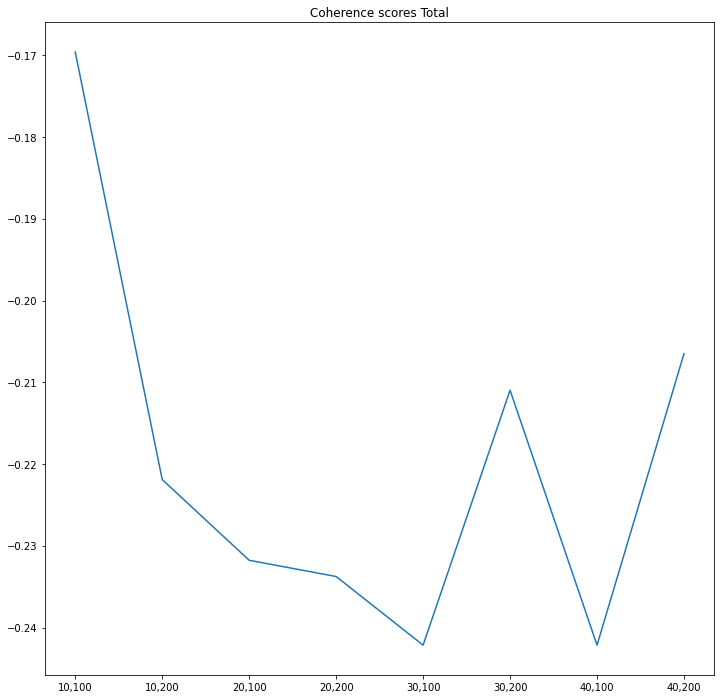

In [51]:
plt.figure(figsize = (12,12))
plt.plot(pairs_total, scores_lda_total)
plt.title('Coherence scores Total')
plt.show()

In [52]:
tuned_lda_model_total = models.LdaModel(corpus = bag_total_corpus, num_topics = NUM_TOPICS, chunksize = 5000, id2word = dictionary_total, passes = perfect_params_total[0], iterations = perfect_params_total[1], random_state = 1)

In [53]:
print("Larger Model Results:")
for id in range(NUM_TOPICS):
    print("Topic " + str(id+1) + ":" + tuned_lda_model_total.print_topic(id,10))

Larger Model Results:
Topic 1:0.047*"time" + 0.046*"appointment" + 0.040*"garage" + 0.035*"tyre" + 0.032*"order" + 0.031*"fitting" + 0.023*"company" + 0.021*"email" + 0.020*"take" + 0.018*"staff"
Topic 2:0.076*"tyre" + 0.041*"first" + 0.033*"experience" + 0.028*"time" + 0.026*"fit" + 0.022*"car" + 0.019*"know" + 0.019*"first_time" + 0.017*"buy" + 0.015*"whole"
Topic 3:0.169*"excellent" + 0.124*"service" + 0.086*"price" + 0.067*"excellent_service" + 0.046*"competitive" + 0.033*"tyre" + 0.030*"competitive_price" + 0.021*"company" + 0.018*"competitive_prices" + 0.018*"fitter"
Topic 4:0.075*"tyre" + 0.052*"easy" + 0.044*"great" + 0.041*"hassle" + 0.041*"service" + 0.035*"free" + 0.033*"garage" + 0.033*"order" + 0.031*"online" + 0.029*"company"
Topic 5:0.096*"tyre" + 0.067*"fitter" + 0.045*"choose" + 0.039*"price" + 0.034*"time" + 0.033*"great" + 0.031*"easy" + 0.022*"go" + 0.020*"find" + 0.020*"turn"
Topic 6:0.051*"tyre" + 0.048*"company" + 0.043*"garage" + 0.026*"service" + 0.020*"class" 

In [54]:
topic_vis_large = pyLDAvis.gensim.prepare(tuned_lda_model_total, bag_total_corpus , dictionary_total, sort_topics = False)
pyLDAvis.display(topic_vis_large)

## Model 2 : Gibbs Sampling Dirichlet Mixture Model

In [55]:
!git clone https://github.com/rwalk/gsdmm.git

Cloning into 'gsdmm'...
remote: Enumerating objects: 62, done.
remote: Total 62 (delta 0), reused 0 (delta 0), pack-reused 62
Unpacking objects: 100% (62/62), done.


In [56]:
from gsdmm.gsdmm import MovieGroupProcess

In [57]:
gsdmm_model = MovieGroupProcess(K = 12, n_iters = 16)

In [58]:
dictionary_total = corpora.Dictionary(dataset.Preprocessed_Total)
dictionary_total.filter_extremes(no_below = 15, no_above = 0.12)

In [59]:
results = gsdmm_model.fit(dataset['Preprocessed_Total'], len(dictionary_total))

In stage 0: transferred 8908 clusters with 12 clusters populated
In stage 1: transferred 6641 clusters with 12 clusters populated
In stage 2: transferred 4785 clusters with 12 clusters populated
In stage 3: transferred 3920 clusters with 12 clusters populated
In stage 4: transferred 3601 clusters with 12 clusters populated
In stage 5: transferred 3400 clusters with 12 clusters populated
In stage 6: transferred 3313 clusters with 12 clusters populated
In stage 7: transferred 3237 clusters with 12 clusters populated
In stage 8: transferred 3215 clusters with 12 clusters populated
In stage 9: transferred 3206 clusters with 12 clusters populated
In stage 10: transferred 3182 clusters with 12 clusters populated
In stage 11: transferred 3171 clusters with 12 clusters populated
In stage 12: transferred 3075 clusters with 12 clusters populated
In stage 13: transferred 3124 clusters with 12 clusters populated
In stage 14: transferred 3167 clusters with 12 clusters populated
In stage 15: transfe

In [60]:
try:
    logger_gsdmm = session.logger(gsdmm_model)
except:
    print("No session logging")

No session logging


In [61]:
docs_per_topic = np.array(gsdmm_model.cluster_doc_count)
print("For each topic, the number of documents is : \n", docs_per_topic)

For each topic, the number of documents is : 
 [ 784  321  352  367  794  770 1457  574  799 1251 2316  347]


In [62]:
topic_cluster_indices = docs_per_topic.argsort()[-12:][::-1]  #this step shows the indices of topics based on number of documents in each of them
topic_cluster_indices

array([10,  6,  9,  8,  4,  0,  5,  7,  3,  2, 11,  1])

In [63]:
def get_top_words_topic(model, topic_words, sorted_index, n_terms):
    """
    Function that gives the top keywords per topic given a model.
    :param model: the GSDMM model
    :param topic_words: a distribution of topic words
    :param sorted_index: an array of topic indices sorted by quantity of documents in each
    :param n_terms: integer representing number of terms to display
    :return: top words for each topic
    """
    for topic in sorted_index:
        topic_terms = sorted(model.cluster_word_distribution[topic].items(), key = lambda k: k[1], reverse = True)
        print("\n\nTopic " + str(topic))
        print("\nWords:", topic_terms[:n_terms])

In [64]:
get_top_words_topic(gsdmm_model, gsdmm_model.cluster_word_distribution, topic_cluster_indices, 25)



Topic 10

Words: [('service', 1535), ('good', 1170), ('price', 963), ('great', 865), ('easy', 559), ('excellent', 511), ('good_price', 434), ('tyre', 387), ('value', 354), ('excellent_service', 293), ('quick', 262), ('efficient', 214), ('money', 148), ('good_value', 145), ('recommend', 141), ('garage', 124), ('great_prices', 100), ('hassle', 97), ('great_value', 91), ('fitting', 89), ('quality', 84), ('company', 83), ('simple', 79), ('free', 76), ('website', 73)]


Topic 6

Words: [('tyre', 802), ('price', 791), ('easy', 719), ('good', 705), ('garage', 454), ('service', 331), ('local', 320), ('good_price', 305), ('great', 299), ('choice', 228), ('local_garage', 180), ('website', 176), ('excellent', 171), ('order', 167), ('time', 164), ('fitting', 153), ('fitter', 152), ('choose', 130), ('quick', 129), ('fit', 124), ('convenient', 119), ('online', 98), ('simple', 94), ('company', 92), ('best_price', 92)]


Topic 9

Words: [('tyre', 1055), ('easy', 603), ('time', 478), ('price', 449), 

In [65]:
def predict_gsdmm_topics(data, model, threshold = 0.5):
    scores = model.score(data)
    score_cluster_map = {i:scores[i] for i in range(len(scores))}
    # print(score_cluster_map)
    sorted_indices = sorted(score_cluster_map, key = lambda k: score_cluster_map[k], reverse = True)
    labels = []
    
    for k in range(0, len(sorted_indices) - 1):
        # print(score_cluster_map[sorted_indices[k]], score_cluster_map[sorted_indices[k+1]], score_cluster_map[sorted_indices[k+1]] - score_cluster_map[sorted_indices[k]] )
        if score_cluster_map[sorted_indices[k]] >= threshold:
            labels.append(sorted_indices[k])
        elif (score_cluster_map[sorted_indices[k]] - score_cluster_map[sorted_indices[k+1]]) < 0.001 and score_cluster_map[sorted_indices[0]] - score_cluster_map[sorted_indices[k+1]] < 0.01:
            labels.append(sorted_indices[k])
    if labels == []:
        labels.append(sorted_indices[0])
    
    labels = labels[:3]
    
#     for i in labels:
#         print(score_cluster_map[i])
          
    # print(sorted_indices)
    
    return str(labels)
        

In [66]:
dataset.loc[1000,'Review']

'Easy to select tyres, easy to select fitting station and good service'

In [67]:
predict_gsdmm_topics(dataset.loc[1000,'Preprocessed_Total'], gsdmm_model, 0.001)

'[6]'

In [68]:
dataset['GSDMM_Topics'] = dataset['Preprocessed_Total'].apply(lambda x: predict_gsdmm_topics(x, gsdmm_model, 0.1))

In [69]:
dataset.sample(5).loc[:,['Review','GSDMM_Topics']].values

array([['Used them many times - never had a problem - always competitive.',
        '[1]'],
       ['Great prices, easy to navigate, will be using again.',
        '[10, 6, 8]'],
       ['Great buying experience from start to finish.', '[8]'],
       ['Great service! Easy to use and efficient in execution. Next time I need tyres, Black-circles will be my choice.',
        '[1]'],
       ['I was satisfied with the service I received', '[10, 0, 1]']],
      dtype=object)

## Method 3 :  Contextualized Topic Models

In [70]:
!pip install contextualized-topic-models==2.2.0

     |████████████████████████████████| 78 kB 2.6 MB/s 
     |████████████████████████████████| 785 kB 19.2 MB/s 
     |████████████████████████████████| 121 kB 48.6 MB/s 
     |████████████████████████████████| 126 kB 40.7 MB/s 
     |████████████████████████████████| 126 kB 40.5 MB/s 
     |████████████████████████████████| 125 kB 66.3 MB/s 
     |████████████████████████████████| 125 kB 65.0 MB/s 
     |████████████████████████████████| 124 kB 68.2 MB/s 
     |████████████████████████████████| 124 kB 62.7 MB/s 
     |████████████████████████████████| 123 kB 66.1 MB/s 
     |████████████████████████████████| 123 kB 66.5 MB/s 
     |████████████████████████████████| 122 kB 65.2 MB/s 
     |████████████████████████████████| 122 kB 71.0 MB/s 
     |████████████████████████████████| 122 kB 68.9 MB/s 
     |████████████████████████████████| 122 kB 69.2 MB/s 
     |████████████████████████████████| 122 kB 69.9 MB/s 
     |████████████████████████████████| 122 kB 71.1 MB/s 
     |██████████

In [71]:
from contextualized_topic_models.models.ctm import CombinedTM
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation
from contextualized_topic_models.evaluation.measures import CoherenceUCI

In [72]:
preprocessed_list = []
for item in dataset.Preprocessed_Total:
    preprocessed_list.append(' '.join(item))
to_dictionary = [string.split() for string in preprocessed_list]

In [73]:
tp = TopicModelDataPreparation("paraphrase-distilroberta-base-v1")

training_dataset = tp.fit(text_for_contextual= dataset.Normalized, text_for_bow = preprocessed_list)

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/718 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/51 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [74]:
%env TOKENIZERS_PARALLELISM = true

env: TOKENIZERS_PARALLELISM=true


In [75]:
ctm = CombinedTM(bow_size=len(tp.vocab), contextual_size=768, n_components=12, num_epochs=50)
ctm.fit(training_dataset)
coh_model = CoherenceUCI(topics = ctm.get_topic_lists(), texts = to_dictionary)
coherence_score = coh_model.score()

Epoch: [50/50]	 Seen Samples: [506600/506600]	Train Loss: 76.41507662815677	Time: 0:00:11.104643: : 50it [09:02, 10.84s/it]


In [76]:
try:
    logger_ctm = session.logger(ctm)
except:
    print("No session logging")

No session logging


In [77]:
print("Coherence score:", coherence_score)

Coherence score: -2.8895740061525768


In [78]:
# lda_vis_data = ctm.get_ldavis_data_format(tp.vocab, training_dataset, n_samples=40)

# ctm_pd = pyLDAvis.prepare(**lda_vis_data)
# pyLDAvis.display(ctm_pd)

In [79]:
# logger_ctm.close()
# logger_gsdmm.close()
# logger_lda.close()

# Section 3 : Topic Allocation

Note : The topic allocation here will be done with respect to LDA.

In [80]:
dataset.sample()

,Review,Normalized,Preprocessed,Preprocessed_Total,Topics,GSDMM_Topics
7833,Hassle free. On time.,hassle free on time,"[hassle, time]","[hassle, free, time]","[5, 6]","[9, 10]"


In [81]:
dataset['Topics_2'] = results

In [82]:
# dataset['Topics_Total'] = dataset['Preprocessed_Total'].apply(lambda x : predict_topics(x, tuned_big_model, dictionary_total))

In [83]:
dataset.sample(15)

,Review,Normalized,Preprocessed,Preprocessed_Total,Topics,GSDMM_Topics,Topics_2
8203,Could not be more simple. Order on line throug...,could not be more simple order online through...,"[order, online, book, time, coffee, thank, hom...","[simple, order, online, good, website, book, f...","[2, 5]",[6],6
9392,"Speedy service, great price. I would definitel...",speedy service great price i would definitel...,"[speedy, service, price]","[speedy, service, great, price, recommend]",[0],[10],10
8201,excellent service. Did what it said on the sit...,excellent service did what it said on the sit...,"[service, site, tyre, fitter, service, station...","[excellent, service, say, site, tyre, fitter, ...","[4, 11]","[6, 1]",6
5091,excellent price and slick service,excellent price and slick service,"[price, service]","[excellent, price, slick, service]",[],[10],10
8319,"5 stars: Excellent – no reservations, I would ...",stars excellent no reservations i would r...,"[star, reservation, company, anyone]","[star, excellent, reservation, recommend, comp...",[8],"[7, 4]",4
9727,Can't beat [REDACTED] for on price & local fit...,cannot beat company for on price and local fit...,"[can, not, company, price, fitting, service]","[can, not, beat, company, price, local, fittin...",[8],[7],7
535,Best deals I could find for 4 Bridgestone tyres,best deals i could find for bridgestone tyres,"[deal, bridgestone, tyre]","[deal, find, bridgestone, tyre]","[4, 11]","[5, 9, 6]",9
37,"PRICE WAS COMPETATIVE, FITTING WAS EASY",price was competative fitting was easy,"[price, fit]","[price, competative, fit, easy]",[11],[6],6
7807,"Great price, great customer experience at the ...",great price great customer experience at the ...,"[price, customer, experience, garage, thing]","[great, price, great, customer, experience, ga...","[8, 10]",[7],7
4812,Great communication throughout. Excellent serv...,great communication throughout excellent serv...,"[communication, service, tyre, excellent_service]","[great, communication, excellent, service, tyr...",[4],[10],4


How many reviews did not get topics assigned to them?

In [84]:
unclustered = dataset[dataset['Topics'].str.len() == 0]
# unclustered.sample(10)

In [85]:
print(str(unclustered.shape[0]) + ' reviews have no topics assigned to them by LDA.')

1754 reviews have no topics assigned to them by LDA.


In [86]:
remaining_data = dataset.drop(unclustered.index, axis = 0)

In [87]:
print("Average length of reviews with topics:", remaining_data['Review'].apply(lambda x: len(x.split())).mean())
print("Average length of reviews without topics:", unclustered['Review'].apply(lambda x: len(x.split())).mean())

Average length of reviews with topics: 24.97290522797804
Average length of reviews without topics: 10.43158494868871


In [88]:
# unclustered[unclustered['Topics_Total'].str.len() == 0]

## Mapping of Topics

Link for logging and visualization : https://medium.com/whylabs/whylogs-embrace-data-logging-a9449cd121d

In [89]:
def tag_topics(data, mapping):
    """Applies mapping on topics list"""
    assert type(data) == type([]), "Data is not a list"
    try:
        return [mapping[x] for x in data]
    except:
        print("No such mapping")
    

In [90]:
dataset['Tagged'] = dataset['Topics'].apply(lambda x: tag_topics(x, lda_model_maps))

In [91]:
dataset.sample(10)

,Review,Normalized,Preprocessed,Preprocessed_Total,Topics,GSDMM_Topics,Topics_2,Tagged
4917,"Easy process, quick results - very good prices.",easy process quick results very good prices,"[process, result, price, good_price, easy_proc...","[easy, process, quick, result, good, price, go...","[0, 4]",[6],6,"[discounts, length of fitting]"
3240,really good good price and service,really good good price and service,"[price, service, good_price]","[good, good, price, service, good_price]",[],[10],10,[]
695,Ease of use and impressed with the service fro...,ease of use and impressed with the service fro...,"[ease, service, garage]","[ease, impressed, service, garage]","[2, 11]","[7, 10, 5]",10,"[booking confusion, garage service]"
2092,"All good. Good tyres, good service",all good good tyres good service,"[tyre, service]","[good, good, tyre, good, service]",[],[10],10,[]
470,Garage fitting didn’t set tyre pressures corre...,garage fitting didnt set tyre pressures correc...,"[garage, do, nt, tyre, pressure, pressure, mon...","[garage, do, nt, tyre, pressure, do, nt, reset...","[2, 8]",[2],2,"[booking confusion, location]"
4232,Great customer service. Great prices,great customer service great prices,"[customer, service, price, customer_service, g...","[great, customer, service, great, price, custo...",[7],[4],4,[value for money]
4551,It was so easy to use select your tyres you wa...,it was so easy to use select your tyres you wa...,"[tyre, class, service, first_class, class_serv...","[easy, select, tyre, want, select, want, go, t...",[6],[1],1,[mobile tyre fitter]
4888,Found the service very straightforward and the...,found the service very straightforward and the...,"[service, mechanic, price]","[find, service, mechanic, helpful, pleasant, r...",[9],"[8, 4]",5,[wait time]
9694,"Quick, reliable and friendly",quick reliable and friendly,[reliable],"[quick, reliable, friendly]",[],"[10, 4]",4,[]
284,Like the website and fitter was great,like the website and fitter was great,"[website, fitter]","[website, fitter, great]","[8, 11]","[6, 8, 10]",8,"[location, garage service]"


In [92]:
dataset.loc[8431, ['Review','Tagged']].values

array(['A quick, easy and efficient service online to order and pay for tyres. I ordered 4 and had them fitted trouble-free within 3 days at a convenient local garage. Would highly recommend [REDACTED].',
       list(['booking confusion'])], dtype=object)

# Classifiers

In [93]:
lda_dataset = pd.DataFrame()
lda_dataset['Review'] = dataset['Review']
columns = ['lda_'+str(i) for i in range(0,12)]

for i, row in dataset.iterrows():
    classes = dataset.loc[i, 'Topics']
    for class_num in classes:
        lda_dataset.loc[i, 'lda_'+ str(class_num)] = 1
lda_dataset.fillna(0, inplace = True)

In [94]:
lda_dataset['Preprocessed'] = dataset['Preprocessed'].apply(lambda x: ' '.join(x))

In [95]:
lda_dataset.sample(5)

,Review,lda_2,lda_6,lda_7,lda_1,lda_9,lda_5,lda_4,lda_3,lda_8,lda_10,lda_0,lda_11,Preprocessed
119,Excellent service. Price is great (fitting inc...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,service price price cost service excellent_ser...
2821,Was originally quoted I would have the tyre fi...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,tyre august be nt tyre be nt issue
1647,Price right and easy to access fitting locally,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,price right access
6910,"Provided good service, no issues. Have used th...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,service issue company doubt
2406,Easy to order great price will use them all th...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,order price time


In [96]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(lda_dataset.Preprocessed)


In [97]:
Y = lda_dataset.loc[:, [column for column in lda_dataset.columns if column.startswith('lda_')]]

In [98]:
Y.head()

,lda_2,lda_6,lda_7,lda_1,lda_9,lda_5,lda_4,lda_3,lda_8,lda_10,lda_0,lda_11
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
from sklearn.model_selection import train_test_split

xtrain,xtest,ytrain,ytest = train_test_split(X , Y, test_size = 0.2, random_state = 0)

In [100]:
from sklearn.metrics import f1_score, accuracy_score

In [101]:
np.array(ytrain).shape

(8105, 12)

In [102]:
ytrain = [ytrain.loc[:, column] for column in columns]

In [103]:
ytest = [ytest.loc[:, column] for column in columns]

## 1. Naive Bayes

In [104]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()

In [105]:

scores_f1 = []
scores_acc = []

count = 0

for sample in ytrain:
    clf.fit(xtrain,sample)
    prediction = clf.predict(xtest)
    scores_f1.append(f1_score(ytest[count], prediction, zero_division = 0))
    scores_acc.append(accuracy_score(ytest[count], prediction))
    count+=1




In [106]:
print("Naive Bayes Mean F1-Score:", np.mean(scores_f1))
print("Naive Bayes Mean Accuracy:", np.mean(scores_acc))
print("Naive Bayes All F1-Scores:", scores_f1)
print("Naive Bayes All Accuracies:", scores_acc)

Naive Bayes Mean F1-Score: 0.2462606080941486
Naive Bayes Mean Accuracy: 0.9156388751850025
Naive Bayes All F1-Scores: [0.08866995073891625, 0.08653846153846152, 0.40633245382585753, 0.24120603015075376, 0.27979274611398963, 0.21316614420062696, 0.34838709677419355, 0.515527950310559, 0.24918032786885247, 0.11976047904191615, 0.21212121212121215, 0.19444444444444445]
Naive Bayes All Accuracies: [0.908732116428219, 0.906265416872225, 0.8889985199802664, 0.9255056734089788, 0.9314257523433646, 0.8761716822890971, 0.9501726689689196, 0.9230389738529847, 0.8870251603354712, 0.9274790330537741, 0.9486926492353231, 0.9141588554514061]


## 2. SVM

In [107]:
# ! pip install delayed

In [108]:
# from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [109]:
X_scaled = StandardScaler().fit_transform(xtrain.toarray())
clf_svm = SVC(gamma='auto')


In [110]:
scores_f1_svm = []
scores_acc_svm = []

count = 0
for sample in ytrain:
    clf_svm.fit(X_scaled,sample)
    prediction = clf_svm.predict(xtest.toarray())
    scores_f1_svm.append(f1_score(ytest[count], prediction, zero_division = 0))
    scores_acc_svm.append(accuracy_score(ytest[count], prediction))
    count+=1

In [111]:
print("SVM Mean F1-Score:", np.mean(scores_f1_svm))
print("SVM Mean Accuracy:", np.mean(scores_acc_svm))
print("SVM All F1-Scores:", scores_f1_svm)
print("SVM All Accuracies:", scores_acc_svm)

SVM Mean F1-Score: 0.0
SVM Mean Accuracy: 0.9010853478046373
SVM All F1-Scores: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
SVM All Accuracies: [0.9047853971386285, 0.9028120374938332, 0.8529847064627528, 0.9141588554514061, 0.9185989146521953, 0.8608781450419339, 0.9368524913665516, 0.8825851011346818, 0.8697582634435126, 0.9230389738529847, 0.9417858904785397, 0.9047853971386285]


## 3. Logistic Regression

In [112]:
from sklearn.linear_model import LogisticRegression

In [113]:
clf_log = LogisticRegression(random_state=0)

In [114]:
scores_f1_log = []
scores_acc_log = []

count = 0
for sample in ytrain:
    clf_log.fit(xtrain,sample)
    prediction = clf_log.predict(xtest)
    scores_f1_log.append(f1_score(ytest[count], prediction, zero_division = 0))
    scores_acc_log.append(accuracy_score(ytest[count], prediction))
    count+=1

In [115]:
print("Logistic Regression Mean F1-Score:", np.mean(scores_f1_log))
print("Logistic Regression Mean Accuracy:", np.mean(scores_acc_log))
print("Logistic Regression All F1-Scores:", scores_f1_log)
print("Logistic Regression All Accuracies:", scores_acc_log)

Logistic Regression Mean F1-Score: 0.7547789154220212
Logistic Regression Mean Accuracy: 0.9605739187633614
Logistic Regression All F1-Scores: [0.7951807228915663, 0.7238095238095238, 0.7779816513761468, 0.7122302158273383, 0.7636363636363637, 0.8096192384769539, 0.8073394495412843, 0.7841191066997519, 0.7318181818181819, 0.6778242677824268, 0.6292134831460674, 0.844574780058651]
Logistic Regression All Accuracies: [0.9664528860384806, 0.957079427725703, 0.9403058707449433, 0.9605328071040947, 0.9679329057720769, 0.9531327084361125, 0.9792797237296498, 0.957079427725703, 0.9417858904785397, 0.9620128268376912, 0.9674395658608781, 0.9738529847064628]
